In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


In [2]:
import os
import numpy as np
from PIL import Image


# Define paths for LR and HR images
lr_dir = '/kaggle/input/urban100/urban100/bicubic_2x/train/LR'
hr_dir = '/kaggle/input/urban100/urban100/bicubic_2x/train/HR'

# Define a common size for all images
common_size_lr = (64, 64)  # Adjust based on your needs
common_size_hr = (256, 256)

# Function to load LR and HR images from separate directories
def load_urban100_images(lr_dir, hr_dir, num_images=None):
    lr_images = []
    hr_images = []
    
    lr_files = sorted(os.listdir(lr_dir))
    hr_files = sorted(os.listdir(hr_dir))
    
    # Ensure the number of LR and HR images match
    assert len(lr_files) == len(hr_files), "Mismatch between LR and HR image counts."

    for idx, (lr_name, hr_name) in enumerate(zip(lr_files, hr_files)):
        if num_images and idx >= num_images:
            break
        
        lr_path = os.path.join(lr_dir, lr_name)
        hr_path = os.path.join(hr_dir, hr_name)
        
        try:
            # Load and resize LR image
            lr_img = Image.open(lr_path).convert('RGB')
            lr_img = lr_img.resize(common_size_lr)
            lr_img = np.array(lr_img)
            lr_images.append(lr_img)
            
            # Load and resize HR image
            hr_img = Image.open(hr_path).convert('RGB')
            hr_img = hr_img.resize(common_size_hr)
            hr_img = np.array(hr_img)
            hr_images.append(hr_img)
            
            # Print out the shape to verify consistency
            print(f"LR Image {idx+1}: {lr_img.shape}, HR Image {idx+1}: {hr_img.shape}")
        
        except Exception as e:
            print(f"Error processing {lr_name} or {hr_name}: {e}")
            continue
    
    # Convert the list of images to NumPy arrays
    lr_images = np.array(lr_images)
    hr_images = np.array(hr_images)
    
#     # Normalize the images to [-1, 1] range
#     lr_images = (lr_images - 127.5) / 127.5
#     hr_images = (hr_images - 127.5) / 127.5
    
    return lr_images, hr_images


In [3]:
lr_images, hr_images = load_urban100_images(lr_dir, hr_dir, num_images=1000)


LR Image 1: (64, 64, 3), HR Image 1: (256, 256, 3)
LR Image 2: (64, 64, 3), HR Image 2: (256, 256, 3)
LR Image 3: (64, 64, 3), HR Image 3: (256, 256, 3)
LR Image 4: (64, 64, 3), HR Image 4: (256, 256, 3)
LR Image 5: (64, 64, 3), HR Image 5: (256, 256, 3)
LR Image 6: (64, 64, 3), HR Image 6: (256, 256, 3)
LR Image 7: (64, 64, 3), HR Image 7: (256, 256, 3)
LR Image 8: (64, 64, 3), HR Image 8: (256, 256, 3)
LR Image 9: (64, 64, 3), HR Image 9: (256, 256, 3)
LR Image 10: (64, 64, 3), HR Image 10: (256, 256, 3)
LR Image 11: (64, 64, 3), HR Image 11: (256, 256, 3)
LR Image 12: (64, 64, 3), HR Image 12: (256, 256, 3)
LR Image 13: (64, 64, 3), HR Image 13: (256, 256, 3)
LR Image 14: (64, 64, 3), HR Image 14: (256, 256, 3)
LR Image 15: (64, 64, 3), HR Image 15: (256, 256, 3)
LR Image 16: (64, 64, 3), HR Image 16: (256, 256, 3)
LR Image 17: (64, 64, 3), HR Image 17: (256, 256, 3)
LR Image 18: (64, 64, 3), HR Image 18: (256, 256, 3)
LR Image 19: (64, 64, 3), HR Image 19: (256, 256, 3)
LR Image 20

In [4]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])


In [5]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [6]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    #op = Conv2D(3, (9,9), padding="same")(layers)
    op = Conv2D(3, (9,9), padding="same",activation = "sigmoid")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [7]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


In [8]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [9]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [10]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

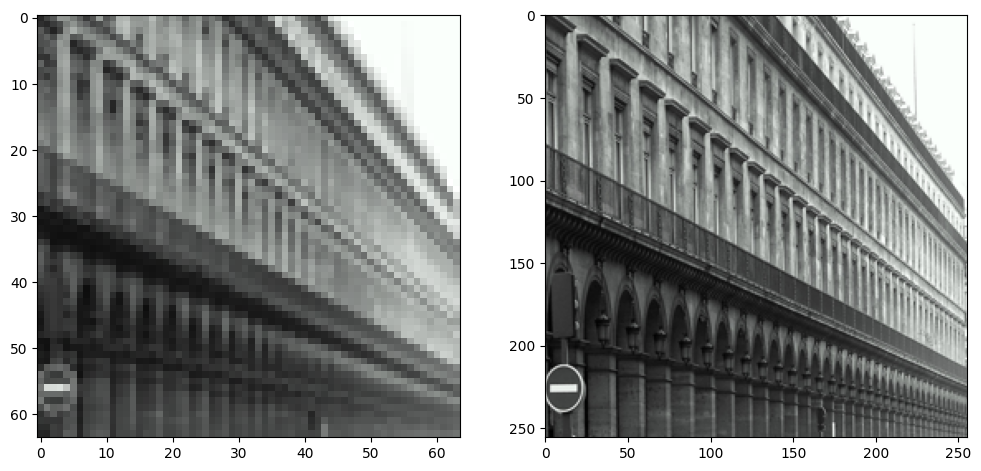

In [11]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (256, 256, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.


In [12]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((256,256,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 64, 64,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 64, 64,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 64, 64,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]  

 Total params: 2,044,291 (7.80 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 4,224 (16.50 KB)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,80

 Total params: 138,912,577 (529.91 MB)

 Trainable params: 138,908,865 (529.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 2,325,568 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256, 256,  │  2,044,291 │ input_layer[0][0] │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 1)         │ 138,912,5… │ functional_1[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 64, 64,    │  2,325,568 │ functional_1[0][… │
│ (Functional)        │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 143,282,436 (546.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 141,242,369 (538.80 MB)

In [14]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    

In [ ]:
epochs = 3
#Enumerate training over epochs
with tf.device('/GPU:0'):
    for e in range(epochs):
        fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
        real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
        #Create empty lists to populate gen and disc losses. 
        g_losses = []
        d_losses = []
    
        #Enumerate training over batches. 
        for b in tqdm(range(len(train_hr_batches))):
            lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
            hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
            fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
            #First, train the discriminator on fake and real HR images. 
            discriminator.trainable = True
            d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
            d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
            #Now, train the generator by fixing discriminator as non-trainable
            discriminator.trainable = False
            #Average the discriminator loss, just for reporting purposes. 
            d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
            del d_loss_gen
            del d_loss_real
            #Extract VGG features, to be used towards calculating loss
            image_features = vgg.predict(hr_imgs)
     
            #Train the generator via GAN. 
            #Remember that we have 2 losses, adversarial loss and content (VGG) loss
            g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
            #Save losses to a list so we can average and report. 
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            del lr_imgs
            del hr_imgs
            del fake_imgs
        
        
        
        #Convert the list of losses to an array to make it easy to average    
        g_losses = np.array(g_losses)
        d_losses = np.array(d_losses)
    
        #Calculate the average losses for generator and discriminator
        g_loss = np.sum(g_losses, axis=0) / len(g_losses)
        d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
        #Report the progress during training. 
        print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
        del g_loss
        del d_loss
        del g_losses
        del d_losses
    

  0%|          | 0/53 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1729005695.987875     104 service.cc:145] XLA service 0x7835b40049f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729005695.987939     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729005695.987945     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729005699.081640     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
generator.save('/kaggle/working/gen_e_final.h5')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy.random import randint

In [ ]:
generator = load_model('/kaggle/working/gen_e_final.h5', compile=False)

In [ ]:
with tf.device('/GPU:1'):
    [X1, X2] = [lr_test, hr_test]
    # select random example
    ix = randint(0, len(X1), 1)
    src_image, tar_image = X1[ix], X2[ix]

    # generate image from source
    gen_image = generator.predict(src_image)


    plt.figure(figsize=(150, 150))
    plt.subplot(231)
    plt.title('LR Image')
    plt.imshow((src_image[0,:,:,:]))
    plt.subplot(232)
    plt.title('Superresolution')
    plt.imshow((gen_image[0,:,:,:]))
    plt.subplot(233)
    plt.title('Orig. HR image')
    plt.imshow((tar_image[0,:,:,:]))

    plt.show()
    del src_image,gen_image,tar_image

